In [1]:
import os
import sys

os.chdir('/data/kebl6672/dpo-toxic')
sys.path.append('/data/kebl6672/dpo-toxic')

In [2]:
"""
Module Doc String
"""

import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
from fancy_einsum import einsum
from transformer_lens import HookedTransformer
from toxicity.figures.fig_utils import convert, load_hooked
from constants import ROOT_DIR, MODEL_DIR

/data/kebl6672/miniconda3/envs/toxic/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 

In [4]:
# Read data
df = pd.read_csv('/data/kebl6672/dpo-toxic-general/toxicity/gpt2_all_neuron_metrics.csv')

In [6]:
df.head()

,layer_idx,neuron_idx,pt_projection_value,dpo_projection_value,pt_activation,dpo_activation,pt_cossim,dpo_cossim,pt_value_vector_projs,dpo_value_vector_projs,projection_diff,activation_diff,dpo_pregelu_activation
0,0,0,-0.004434,-0.004821,-0.086628,-0.094152,0.020808,0.020818,0.051181,0.051206,3.874512e-04,0.007524,-0.230220
1,0,1,0.000381,0.000381,-0.010077,-0.010096,-0.015356,-0.015325,-0.037849,-0.037771,7.888138e-08,0.000019,-0.020527
2,0,2,0.008536,0.008656,-0.065236,-0.066241,-0.044885,-0.044824,-0.130852,-0.130673,-1.195893e-04,0.001005,-0.150482
3,0,3,0.004260,0.004129,-0.081713,-0.079245,-0.015817,-0.015809,-0.052139,-0.052108,1.311275e-04,-0.002468,-0.185906
4,0,4,0.000003,-0.000003,-0.073461,-0.079985,-0.000018,0.000015,-0.000046,0.000038,6.465025e-06,0.006524,-0.188006


#### Calculate percentage of toxicity reduction form 128 toxic neurons

In [7]:
# Select the top 128 rows with the highest cosine similarity
top_128_rows = df.nlargest(128, 'pt_cossim')

# Filter rows with positive 'pt_activation' and 'activation_diff' > 0
filtered_rows = top_128_rows[(top_128_rows['pt_activation'] > 0) & (top_128_rows['activation_diff'] > 0)]

# Sum up the 'projection_diff' for the selected rows
projection_diff_sum = filtered_rows['projection_diff'].sum()

# Print the result
print("Sum of 'projection_diff' for the selected rows:", projection_diff_sum)


Sum of 'projection_diff' for the selected rows: 2.3329712666299134


In [8]:
# Filter rows with positive 'cosine_similarity'
positive_cossim_rows = df[df['pt_cossim'] > 0]

# Further filter rows with positive 'gpt2_activation' and 'activation_diff' > 0
filtered_rows = positive_cossim_rows[(positive_cossim_rows['pt_activation'] > 0) & (positive_cossim_rows['activation_diff'] > 0)]

# Sum up the 'projection_diff' for the selected rows
projection_diff_sum = filtered_rows['projection_diff'].sum()

# Print the result
print("Sum of 'projection_diff' for rows with positive 'cosine_similarity':", projection_diff_sum)


Sum of 'projection_diff' for rows with positive 'cosine_similarity': 15.11076594616289


In [9]:
# Filter rows with positive 'projection_diff'
positive_projection_diff_rows = df[df['projection_diff'] > 0]

# Sum up the 'projection_diff' for the filtered rows
total_projection_diff_sum = positive_projection_diff_rows['projection_diff'].sum()

print("Sum of 'projection_diff' for all rows with positive 'projection_diff':", total_projection_diff_sum)


Sum of 'projection_diff' for all rows with positive 'projection_diff': 47.96267586110679


### Plot value vector toxic alignment vs activation change (no obvious pattern found)

/tmp/ipykernel_2560275/1255975568.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['layer_neuron'] = df_selected['layer_idx'].astype(str) + '_' + df_selected['neuron_idx'].astype(str)


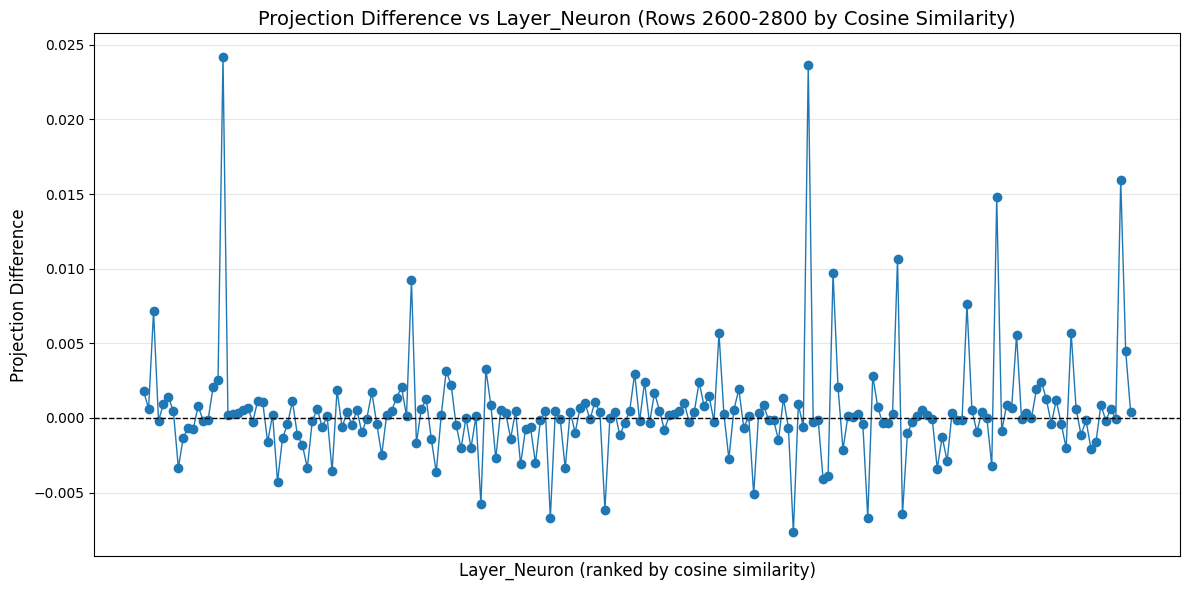

In [12]:
# Sort the DataFrame by cosine_similarity in descending order
df_sorted = df.sort_values(by='pt_cossim', ascending=False)

# Define the range of rows to select
start_row = 2600
end_row = 2800

df_selected = df_sorted.iloc[start_row:end_row]

# Create a new column for x-axis labels combining layer and neuron indices
df_selected['layer_neuron'] = df_selected['layer_idx'].astype(str) + '_' + df_selected['neuron_idx'].astype(str)

# Plot the line chart
plt.figure(figsize=(12, 6))
plt.plot(df_selected['layer_neuron'], df_selected['projection_diff'], marker='o', linestyle='-', linewidth=1)

plt.xlabel('Layer_Neuron (ranked by cosine similarity)', fontsize=12)
plt.ylabel('Projection Difference', fontsize=12)
plt.title(f'Projection Difference vs Layer_Neuron (Rows {start_row}-{end_row} by Cosine Similarity)', fontsize=14)
plt.xticks([], fontsize=8) 
plt.grid(alpha=0.3)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1) # Add a black line at 0 in x-axis

# Show the plot
plt.tight_layout()
plt.show()


/tmp/ipykernel_2560275/2961686318.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['layer_neuron'] = df_selected['layer_idx'].astype(str) + '_' + df_selected['neuron_idx'].astype(str)


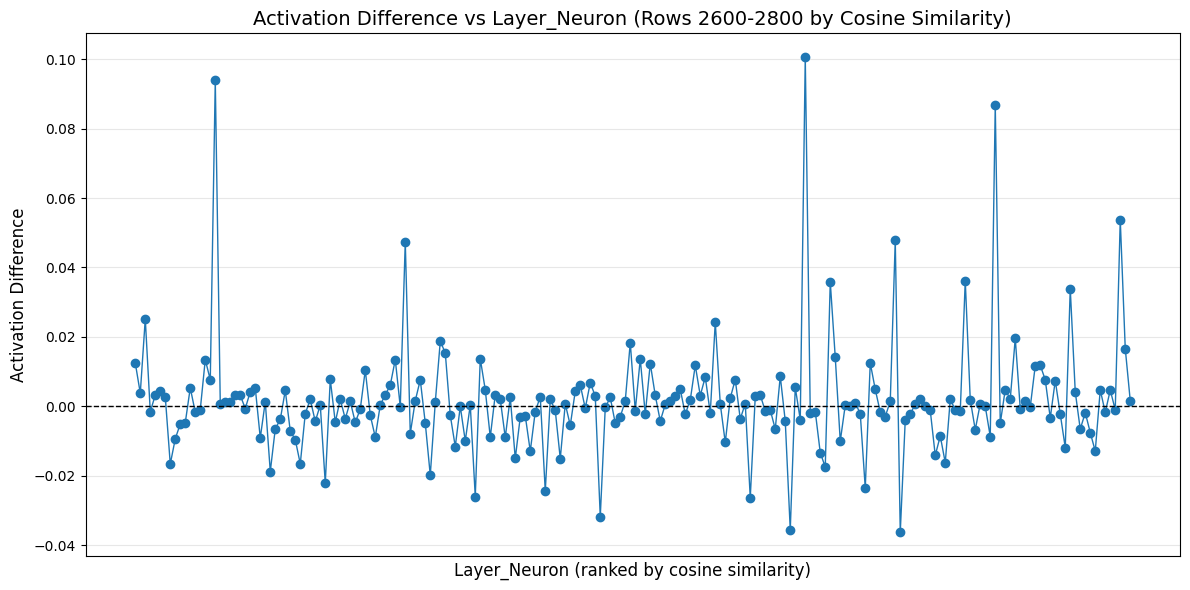

In [14]:
# Sort the DataFrame by cosine_similarity in descending order
df_sorted = df.sort_values(by='pt_cossim', ascending=False)

# Define the range of rows to select
start_row = 2600
end_row = 2800

df_selected = df_sorted.iloc[start_row:end_row]

# Create a new column for x-axis labels combining layer and neuron indices
df_selected['layer_neuron'] = df_selected['layer_idx'].astype(str) + '_' + df_selected['neuron_idx'].astype(str)

# Plot the line chart
plt.figure(figsize=(12, 6))
plt.plot(df_selected['layer_neuron'], df_selected['activation_diff'], marker='o', linestyle='-', linewidth=1)

plt.xlabel('Layer_Neuron (ranked by cosine similarity)', fontsize=12)
plt.ylabel('Activation Difference', fontsize=12)
plt.title(f'Activation Difference vs Layer_Neuron (Rows {start_row}-{end_row} by Cosine Similarity)', fontsize=14)
plt.xticks([], fontsize=8) 
plt.grid(alpha=0.3)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1) # Add a black line at 0 in x-axis

# Show the plot
plt.tight_layout()
plt.show()


/tmp/ipykernel_2560275/2099438932.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['layer_neuron'] = df_selected['layer_idx'].astype(str) + '_' + df_selected['neuron_idx'].astype(str)


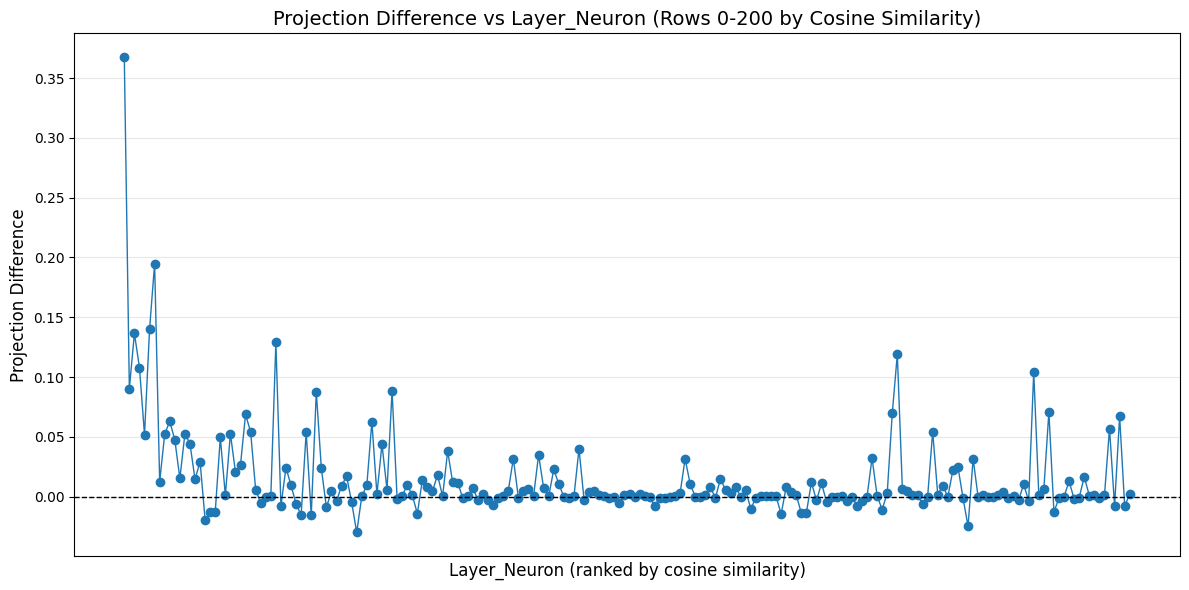

In [13]:
# Sort the DataFrame by cosine_similarity in descending order
df_sorted = df.sort_values(by='pt_cossim', ascending=False)

# Define the range of rows to select (e.g., 2000 to 4000)
start_row = 0
end_row = 200

# Slice the DataFrame to the selected range
df_selected = df_sorted.iloc[start_row:end_row]

# Create a new column for x-axis labels combining layer and neuron indices
df_selected['layer_neuron'] = df_selected['layer_idx'].astype(str) + '_' + df_selected['neuron_idx'].astype(str)

# Plot the line chart
plt.figure(figsize=(12, 6))
plt.plot(df_selected['layer_neuron'], df_selected['projection_diff'], marker='o', linestyle='-', linewidth=1)

# Formatting the plot
plt.xlabel('Layer_Neuron (ranked by cosine similarity)', fontsize=12)
plt.ylabel('Projection Difference', fontsize=12)
plt.title(f'Projection Difference vs Layer_Neuron (Rows {start_row}-{end_row} by Cosine Similarity)', fontsize=14)
plt.xticks([], fontsize=8)  # Optional: Omit x-ticks for readability, as there might be many.
plt.grid(alpha=0.3)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1) # Add a black line at 0 in x-axis

# Show the plot
plt.tight_layout()
plt.show()


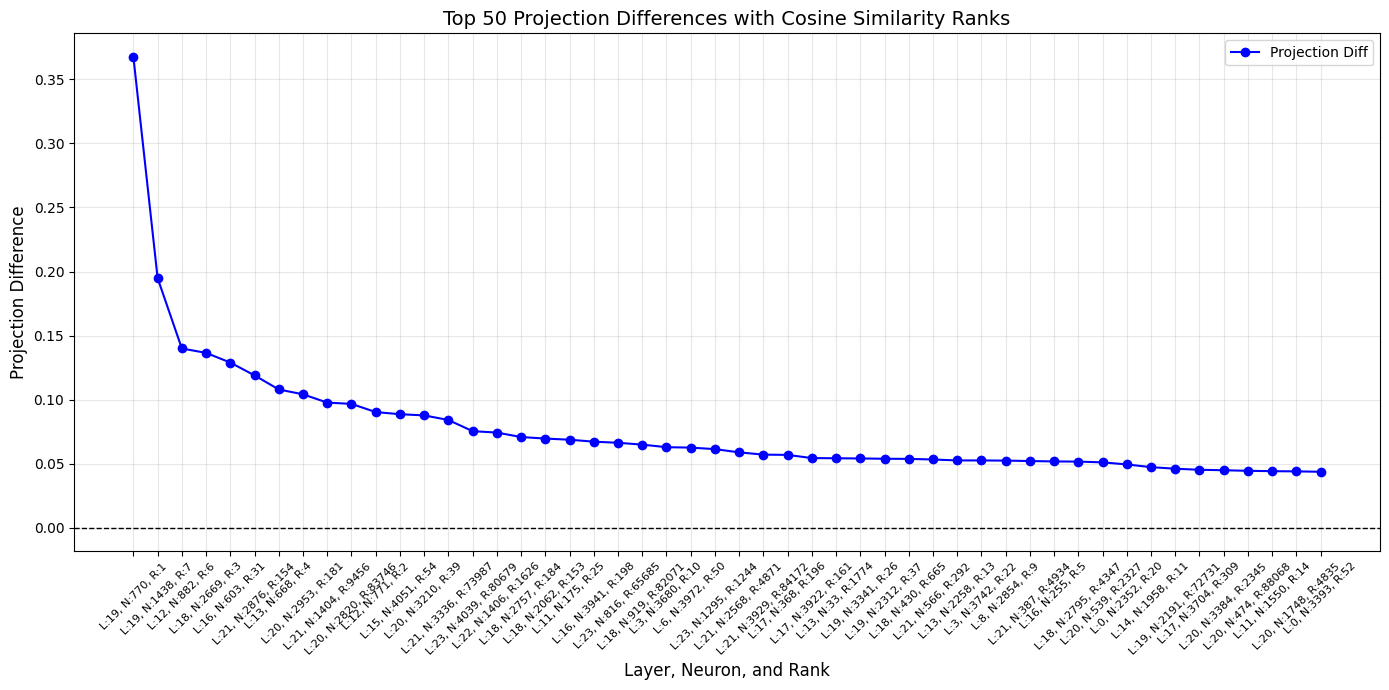

In [15]:
# Sort the DataFrame by cosine_similarity in descending order to compute ranks
df['cosine_similarity_rank'] = df['pt_cossim'].rank(ascending=False, method='first')

# Sort the DataFrame by projection_diff in descending order
df_sorted = df.sort_values(by='projection_diff', ascending=False)

# Select the top 50 rows by projection_diff
df_top_50 = df_sorted.head(50)

# Create x-axis labels with layer, neuron, and rank information
x_labels = [
    'L:{}, N:{}, R:{}'.format(
        int(row['layer_idx']), 
        int(row['neuron_idx']), 
        int(row['cosine_similarity_rank'])
    ) for _, row in df_top_50.iterrows()
]

# Plot the top 50 projection_diff values
plt.figure(figsize=(14, 7))
plt.plot(x_labels, df_top_50['projection_diff'], marker='o', linestyle='-', color='blue', label='Projection Diff')

# Formatting the plot
plt.xlabel('Layer, Neuron, and Rank', fontsize=12)
plt.ylabel('Projection Difference', fontsize=12)
plt.title('Top 50 Projection Differences with Cosine Similarity Ranks', fontsize=14)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Add horizontal line at y=0
plt.xticks(rotation=45, fontsize=8)  # Rotate x-axis labels for readability
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()
